# Analyze A/B Test Results 

Project done by: Mostafa Helmy

github: http://github.com/helmyy99

This project runs an A/B test on a website and analyze it results. This notebook contains the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)



<a id='intro'></a>
## Introduction

This project aims to understand the results of an A/B test run by an e-commerce website to get user responses on a new webpage design update and wether users prefer the old or the new page.


<a id='probability'></a>
## Part I - Probability


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

**Loading the Data Set**

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**The total number of users in the dataset**

In [3]:
df.shape[0]

294478

**The number of unique users in the dataset**

In [4]:
df['user_id'].nunique()

290584

**The proportion of users converted**

In [5]:
df.query("converted == 1")['user_id'].nunique() / df['user_id'].nunique()

0.12104245244060237

**The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`**

In [6]:
df.query("group == 'treatment' and landing_page != 'new_page'")['user_id'].nunique()

1965

**Checking missing values**

In [7]:
df.isnull().values.any()

False

**Removing the inaccurate rows, and storing the result in a new dataframe df2**

In [8]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**Double check all of the incorrect rows were removed from df2**

In [9]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**Unique users in df2**

In [10]:
df2.shape[0]

290585

In [11]:
df2['user_id'].nunique()

290584

**Displaying the rows for a duplicate user_id**

In [12]:
df2[df2.duplicated(subset='user_id', keep='first')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
df2[df2.duplicated(subset='user_id', keep='last')]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


**Removing one of the rows of the duplicate from df2**

In [14]:
df2 = df2.drop(1899)
df2[df2.duplicated(subset='user_id')]

,user_id,timestamp,group,landing_page,converted


**The probability of an individual converting regardless of the page they receive**

In [15]:
Pp = df2.converted.mean()
Pp

0.11959708724499628

**The probability that an individual converted from the `control` group**

In [16]:
P_control = df2.query("group == 'control'")['converted'].mean()
P_control

0.1203863045004612

**The probability that an individual converted from the `treatment` group**

In [17]:
P_treat = df2.query("group == 'treatment'")['converted'].mean()
P_treat

0.11880806551510564

**The actual difference `obs_diff` between the conversion rates for the two groups**

In [18]:
obs_diff = P_control - P_treat
obs_diff

0.0015782389853555567

**The probability that an individual received the new page**

In [19]:
P_page = df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]
P_page

0.5000619442226688

>**According to the estimations above, it doesn't seem that there is an observable difference, in fact the number of the conversion rate of the control group is slightly higher than the treatment group**

<a id='ab_test'></a>
## Part II - A/B Test

We assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%

>**Null H0: Pnew <= Pold , Alternative H1: Pnew > Pold**

Under the null hypothesis $H_0$, we assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, we assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

The code in this section: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

**The conversion rate for $p_{new}$ under the null hypothesis**

In [20]:
Pnull = df2.converted.mean()
Pnew = Pnull
Pnew

0.11959708724499628

**The conversion rate for $p_{old}$ under the null hypothesis**

In [21]:
Pold = Pnull
Pold

0.11959708724499628

**The number of individuals in the treatment group $n_{new}$**

In [22]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145310

**The number of individuals in the control group $n_{old}$

In [23]:
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

**Simulate a Sample for the `treatment` Group**

In [24]:
new_page_converted = np.random.choice(df2.query("group == 'treatment'")['converted'], n_new)
Pnew_ = new_page_converted.mean()
Pnew_

0.11839515518546556

**Simulate a Sample for the `control` Group**

In [25]:
old_page_converted = np.random.choice(df2.query("group == 'control'")['converted'], n_old)
Pold_ = old_page_converted.mean()
Pold_

0.12149455511653841

**The difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for simulated samples**

In [26]:
diff = Pnew_ - Pold_
diff

-0.0030993999310728465


**Re-creating `new_page_converted` and `old_page_converted` and finding the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process before**

In [27]:
new_converted_simulation = np.random.binomial(n_new, Pnew_, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, Pold_, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

In [28]:
p_diffs.mean()

-0.0031040183949106533

**Histogram**

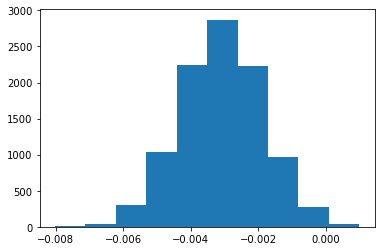

In [29]:
plt.hist(p_diffs);

In [30]:
p_diffs = np.array(p_diffs)

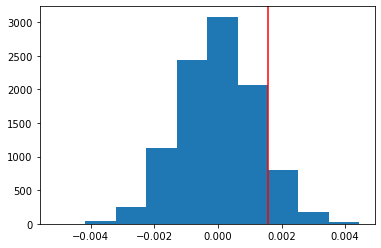

In [31]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

plt.hist(null_vals);
plt.axvline(x=obs_diff, color = 'red'); # where our sample mean falls on null dist

**Proportion of the p_diffs greater than the actual difference observed in the `df2` data**

In [32]:
(null_vals < obs_diff).mean()

0.901

>**Above, the P-value is computed. Since the P-value is more than the Type I error rate (0.05), it can be concluded that the Null hypothesis cannot be rejected, meaning that the new page conversions are greater than the old one.**

**Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Here we calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [33]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("landing_page == 'old_page' and converted == 1")["user_id"].nunique()

# number of conversions with the new_page
convert_new = df2.query("landing_page == 'new_page' and converted == 1")["user_id"].nunique()

# number of individuals who were shown the old_page
n_old = df2.query("landing_page == 'old_page'")["user_id"].nunique()

# number of individuals who received new_page
n_new = df2.query("landing_page == 'new_page'")["user_id"].nunique()

### Two-sample z-test

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. We can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. We can determine the $Z_{\alpha}$ from the z-table manually. 


>For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

In [34]:
count_array = [convert_old, convert_new]
nobs_array = [n_old, n_new]

In [35]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


>**Since the Zscore is less than 1.645, then it means that the null hypothesis cannot be rejected.**

>**The p-value appears to be nearly equal to the one computed earlier in the A/B test.**

>**These results matches the ones appeared in the A/B test.**

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the results achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**Since each row in the `df2` data is either a conversion or no conversion, the type of regression should you be performing in this case is:**

>**Logistic Regressoin**

In [36]:
df2['intercept'] = 1
df2['ab_page'] = [1 if x == 'treatment' else 0 for x in df2['group']]
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [37]:
mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

In [38]:
results = mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-12-10 14:39 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

>**The p-value associated with ab_page = 0.189, which is higher than the Type I error rate (0.05), meaning that the null hypothesis cannot be rejected. However, it is a lot lower than the one computed in Part II**

>**Because the Logistic Regression predicts the log odd (i.e.: the probability of an event occuring) instead of predicting the response itself.**

>**It is good to consider other factors to add because it may influence the decesion of the user and will make us look at the results differently. However, it may cause some problems like correlated errors, non-constant variance, , outliers, multicollinearity, or a linear relation might not exist.**

**Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives in.

In [39]:
df_conuntries = pd.read_csv('countries.csv')
df_conuntries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
# Join with the df2 dataframe
df_merged = df2.set_index('user_id').join(df_conuntries.set_index('user_id'))

In [41]:
# Creating the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [42]:
# Fit your model, and summarize the results
df_merged['CA_group'] = df_merged['CA']*df_merged['ab_page']
df_merged['UK_group'] = df_merged['UK']*df_merged['ab_page']
df_merged['US_group'] = df_merged['US']*df_merged['ab_page']
mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'CA', 'UK', 'CA_group', 'UK_group']])
results = mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.9259
Date:               2021-12-10 14:39 BIC:              212835.8241
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           4                LL-Null:          -1.0639e+05
Df Residuals:       290579           LLR p-value:      0.27295    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0073    0.0371    -0.1963  0.8444  -0.0799   0.0654
UK            0.0045    0.0175     0.2572  0.7970  -0.0298   0.0389
CA_group     -0.0674    0.0520    -1.2967  0.1947  -0.1694   0.0345
UK_group      0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
==================================================================

"""

In [43]:
np.exp(0.0045)

1.0045101402046013

In [44]:
1/np.exp(-0.0073)

1.0073267099546657

In [45]:
np.exp(0.0108)

1.010858530520097

In [46]:
1/np.exp(-0.0674)

1.0697232819209153

>**From the above summary we can conclude the following:**

>**1. A user from the UK is 1.0045 times more likely to convert than a US user holding all other variables constants**

>**2. A user from the UK treatment group is 1.0109 times more likely to convert than a US user from the treatment group holding all other variables constants**

>**3. A user from canada is 1.0073 times less likely to convert than a US user holding all other variables constants**

>**4. A user from the canadian treatment group is 1.0697 times less likely to convert than a US user from the treatment group holding all other variables constants**